In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.utils import custom_cutout
from data.load_fluo import get_src, get_data, get_patched_src, get_patched_data
from data.load import subsample
from model.metrics import psnr, ssim
from model.networks import custom_channel_resnet34
from model.bpho.resnet import *
from model.bpho.unet import *
from model.bpho.multi import *

## Choose Devices

In [4]:
gpu_id = 5
num_cores = 4
torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [5]:
nb_name = 'critic_fluorescence_single'

## Load Data

### Single or multiple frame critic?

In [6]:
lr_type='s' # or 't'

In [7]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/critics')  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets
/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/critics


In [8]:
def patch(min_n=100, max_n=120, min_len=8, max_len=10):
    random_patch = partial(custom_cutout, min_n_holes=min_n, max_n_holes=max_n,
                           min_length=min_len, max_length=max_len, use_on_y=False)
    tfms = [[random_patch()], [random_patch()]]
    return tfms
tfms = patch()

In [9]:
data = get_patched_data(8, 256, lr_tifs, hr_tifs, tfms=tfms)

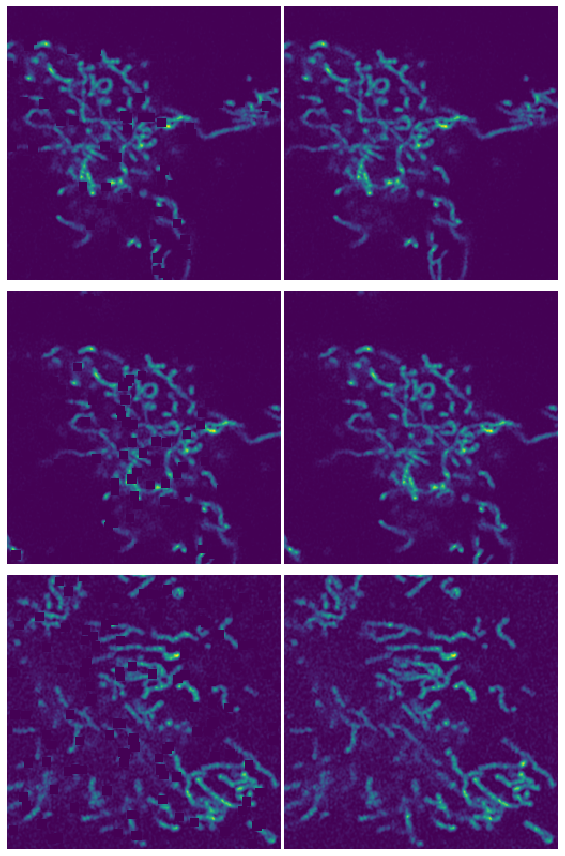

In [10]:
data.show_batch(rows=3)

## Data Subsample

In [11]:
data = subsample(data)

In [12]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(62, 3)

# Model

## Initialization

In [13]:
arch = custom_channel_resnet34
arch = partial(arch, c_in=1)

In [14]:
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]
learn = unet_learner(data, arch, 
                     pretrained=False,
                     wd=wd, 
                         #loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/critics


## Load Model (optional)

In [16]:
learn = learn.load(f'{nb_name}.2a')

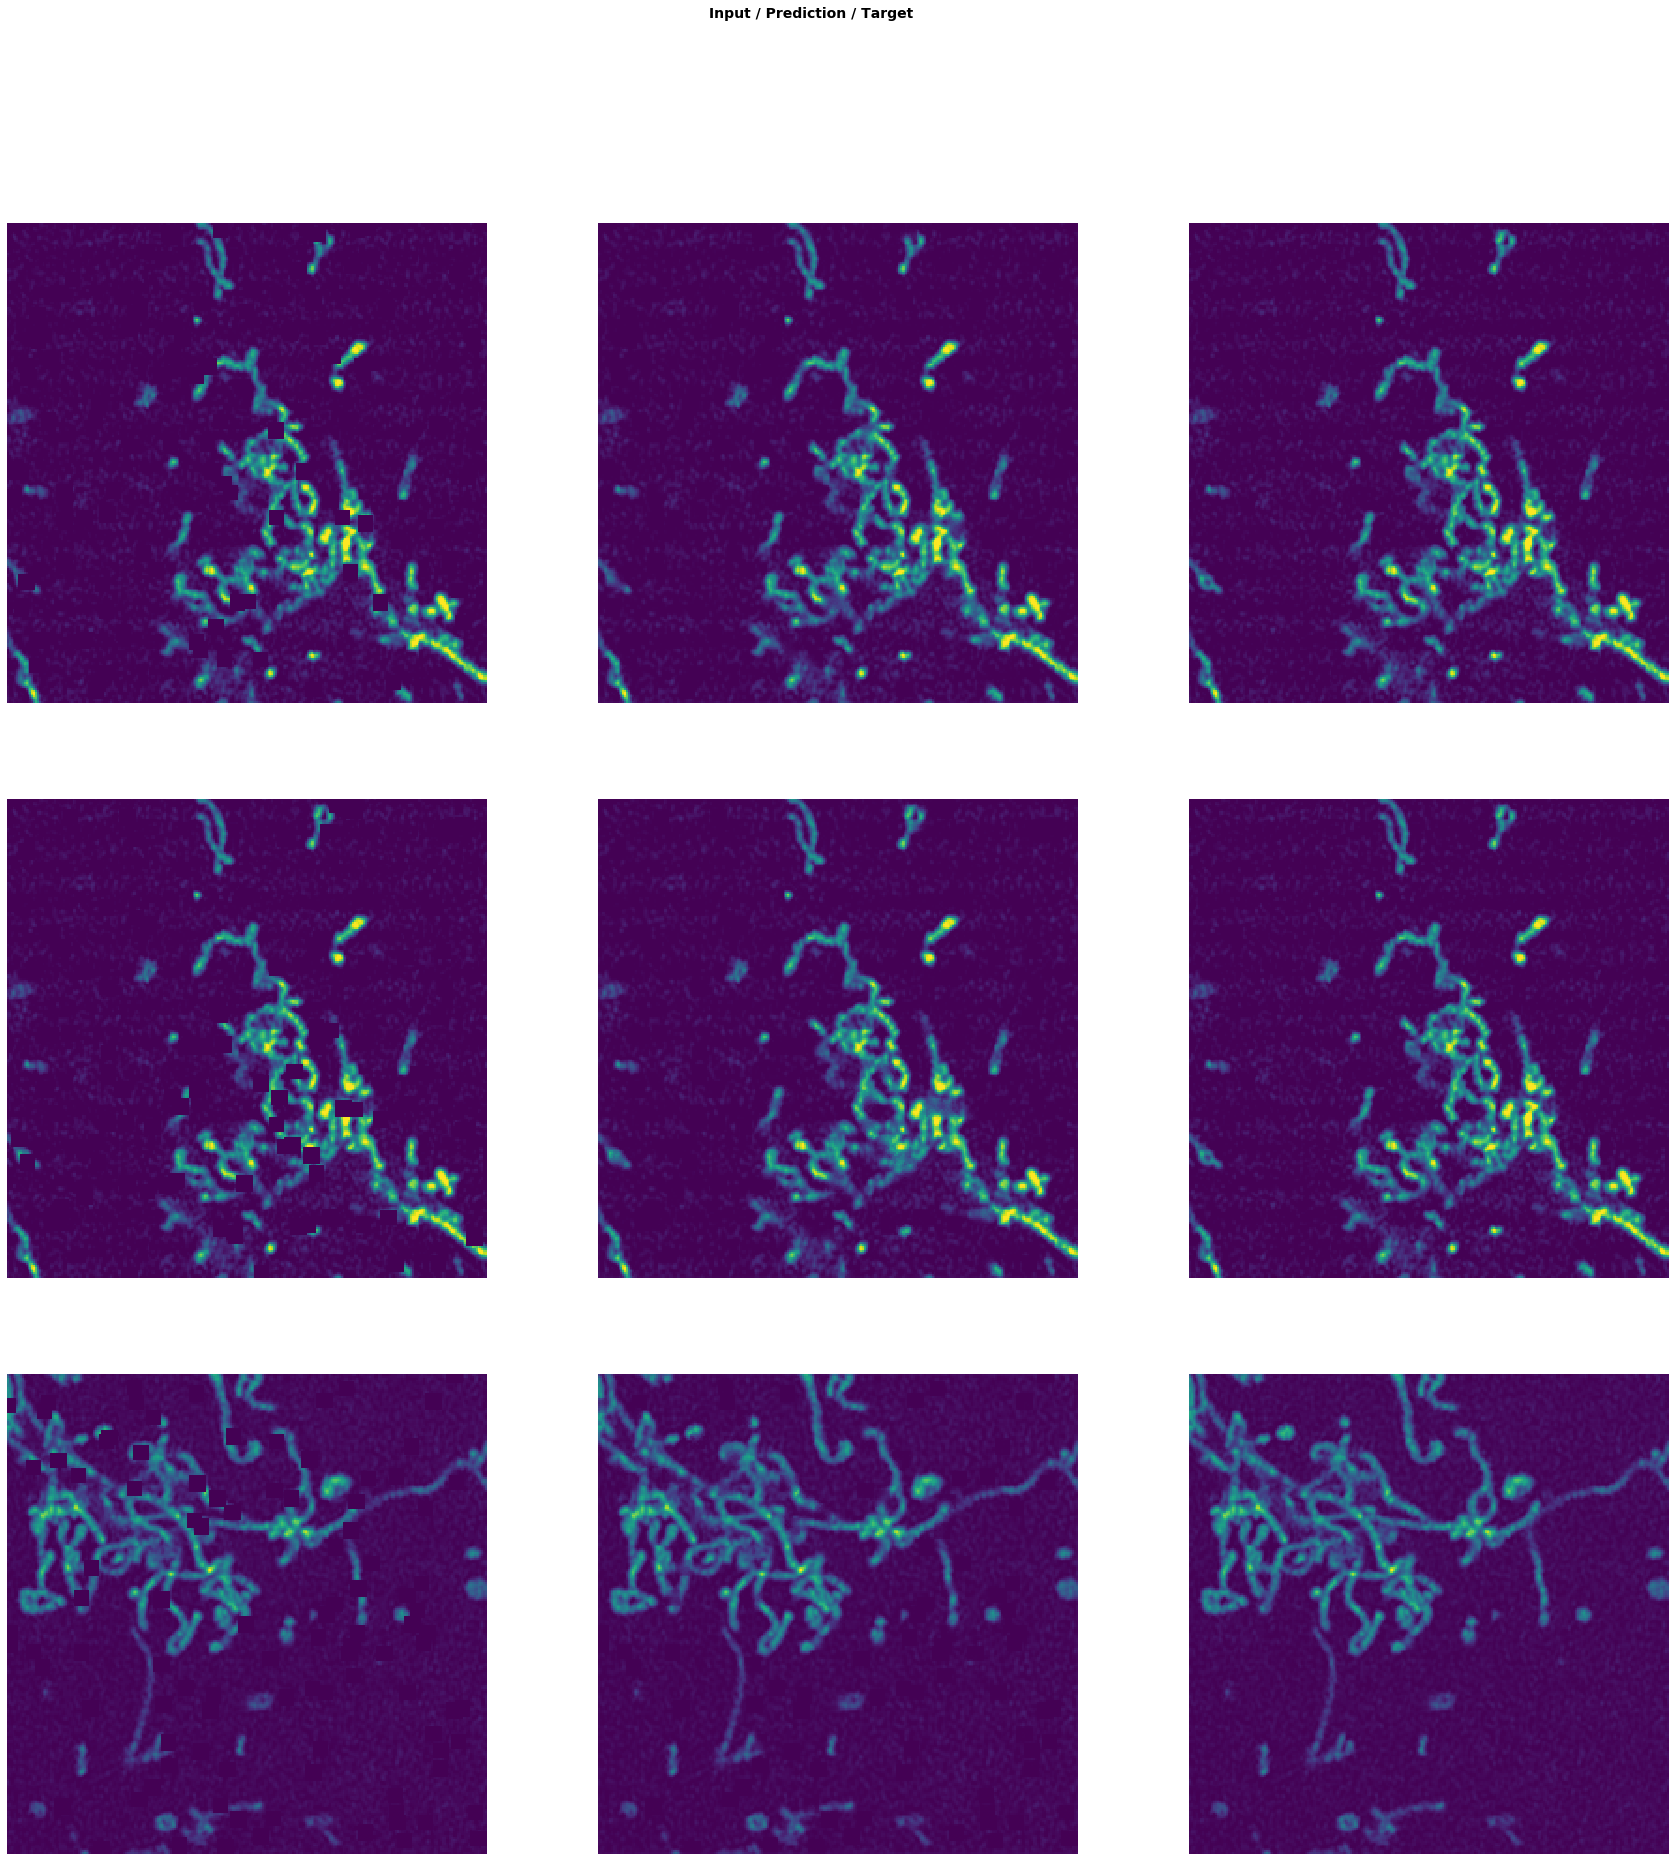

In [17]:
learn.show_results(rows=3, figsize=(30, 30))

## Training

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


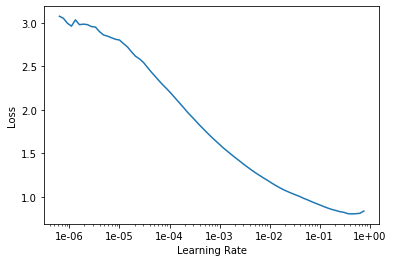

In [26]:
learn.recorder.plot()

### 1a: total 1 epoch

In [27]:
lr = slice(1e-4, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

### 1b: total 4

In [97]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [100]:
lr = slice(5e-5, 5e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

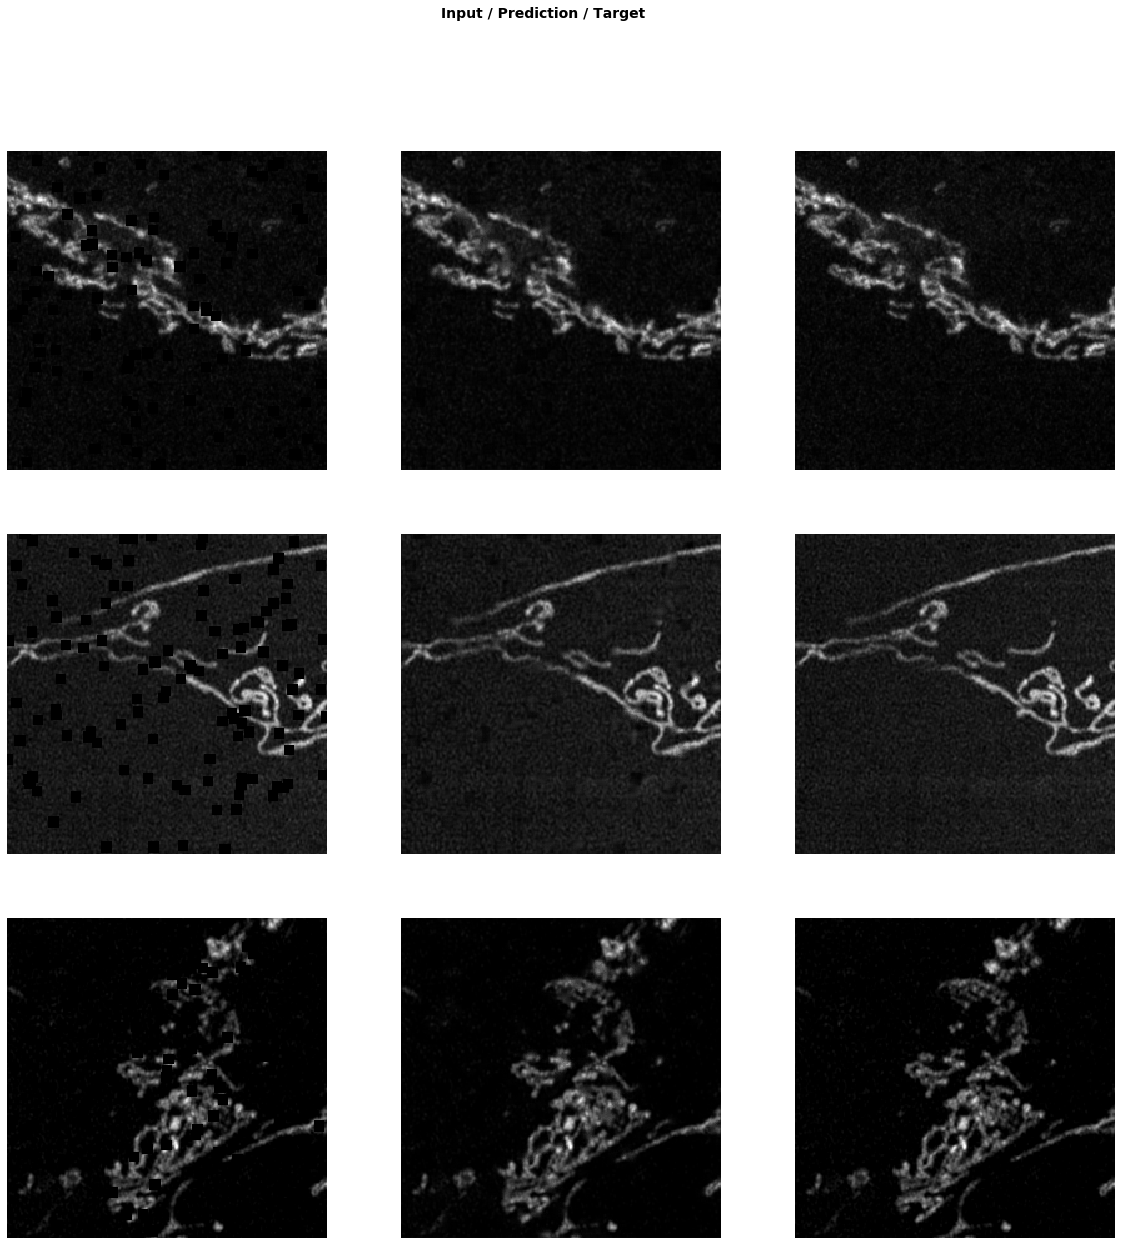

In [105]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

### 1c: total 7

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


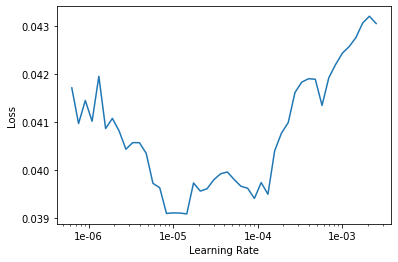

In [106]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [107]:
lr = slice(3e-6, 1e-5)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1c', with_opt=False)

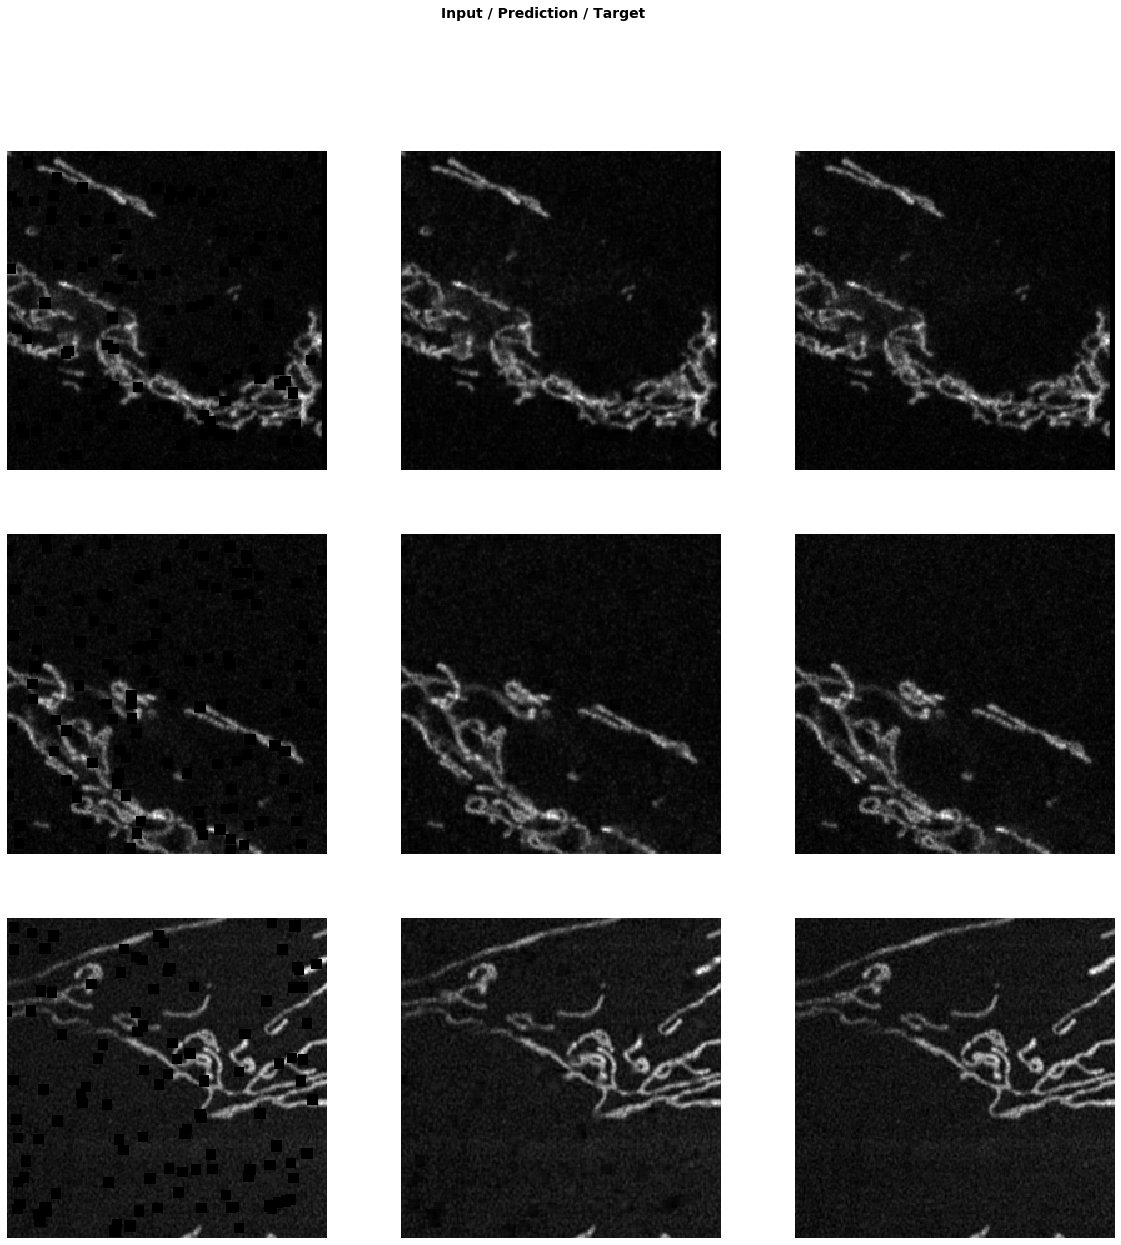

In [111]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

### 1d: total 10

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


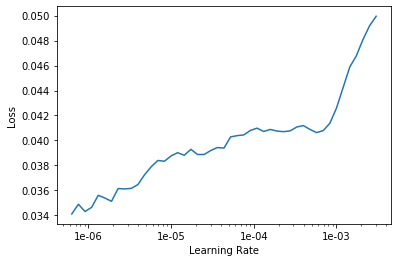

In [112]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [113]:
lr = slice(1e-6, 5e-6)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1d', with_opt=False)

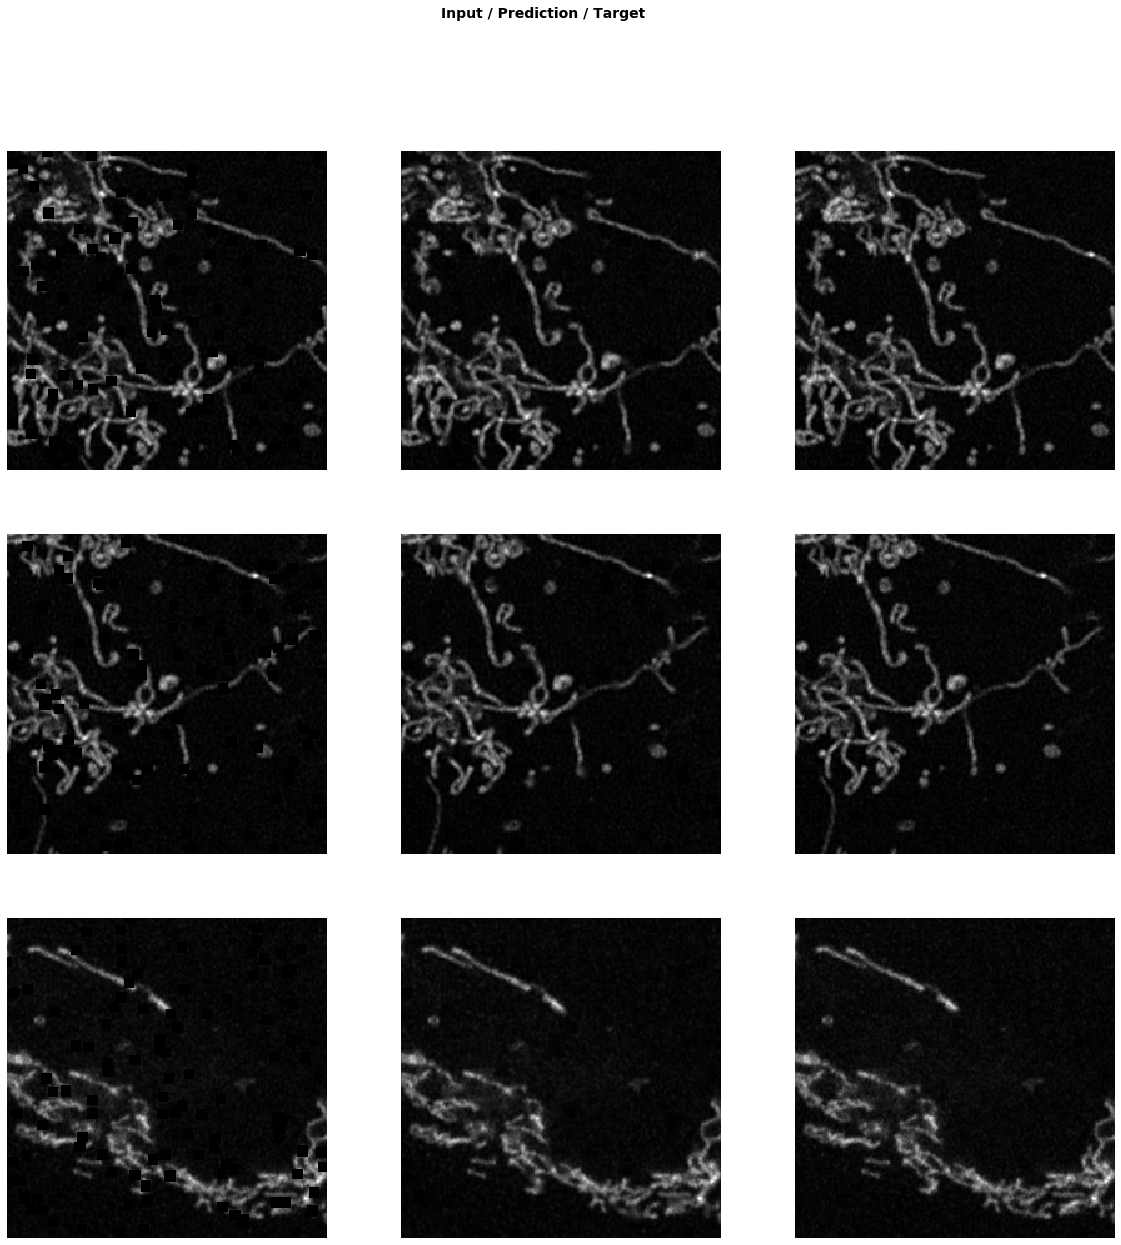

In [116]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

### 1e: total 13

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


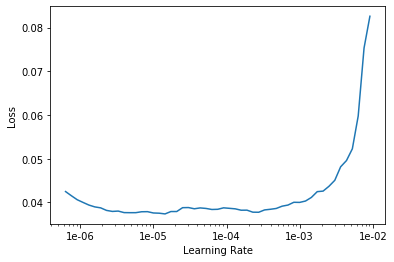

In [117]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [118]:
lr = slice(1e-5, 1e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1e', with_opt=False)

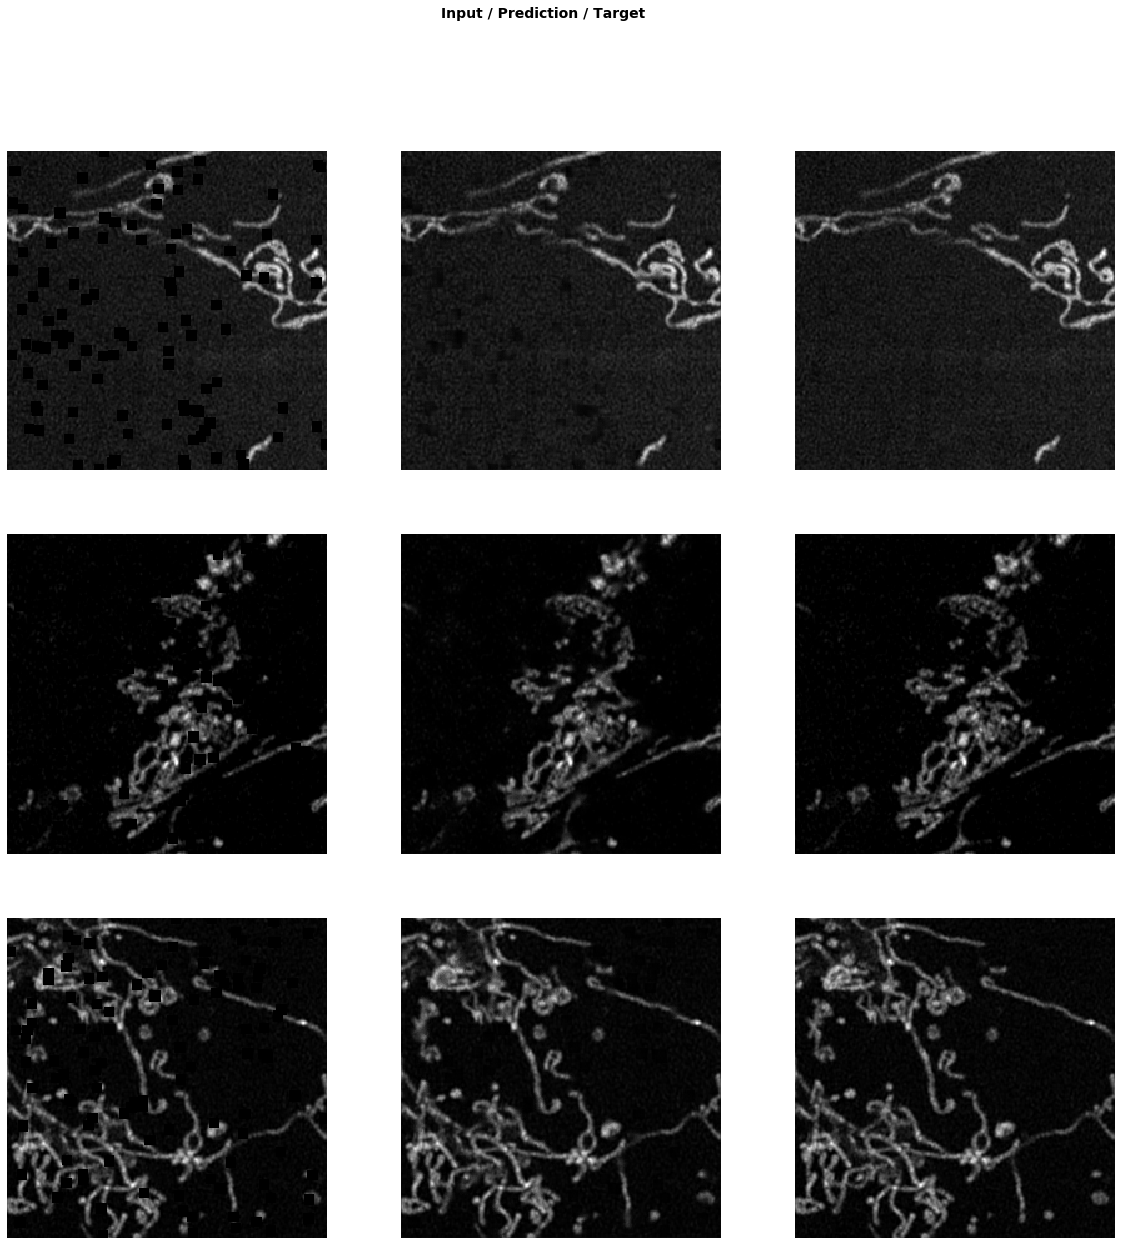

In [119]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

### 1f: total 16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


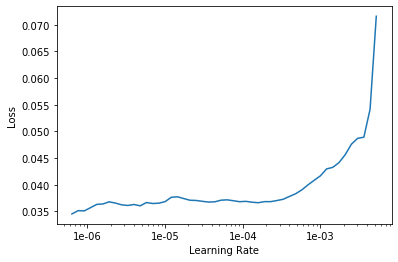

In [120]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [121]:
lr = slice(1e-6, 5e-6)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1f', with_opt=False)

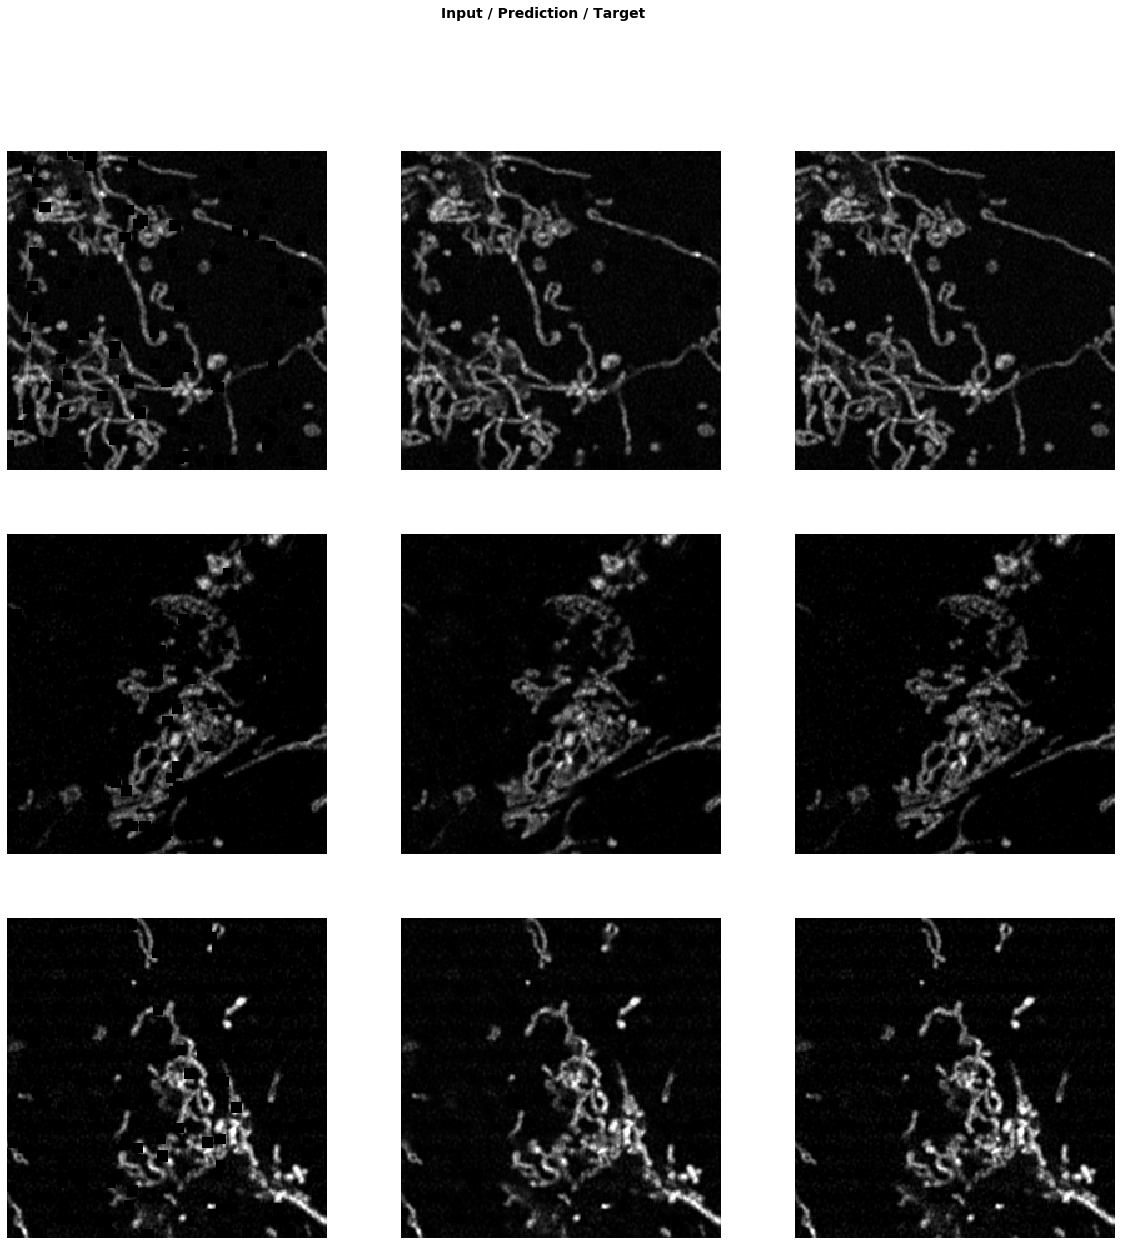

In [122]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

### 1g: total 19

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


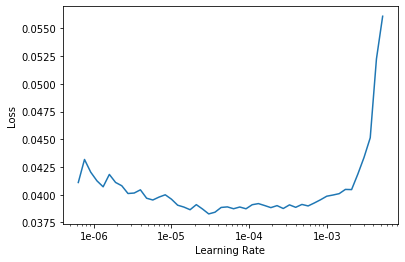

In [123]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [124]:
lr = slice(5e-6, 5e-5)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1g', with_opt=False)

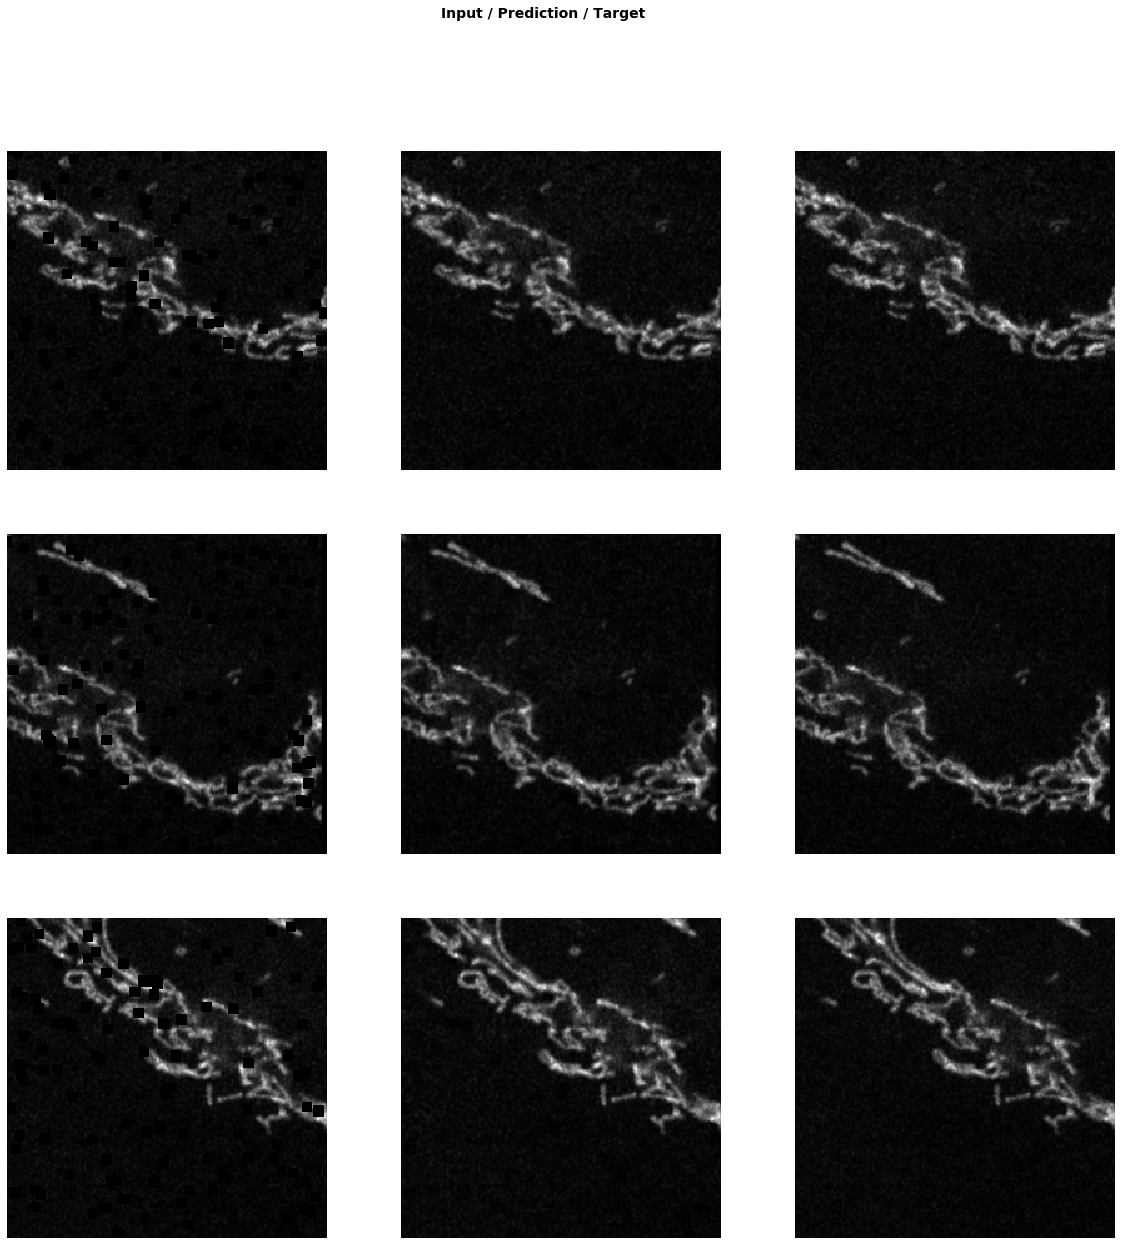

In [125]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

### 2a: total 22

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


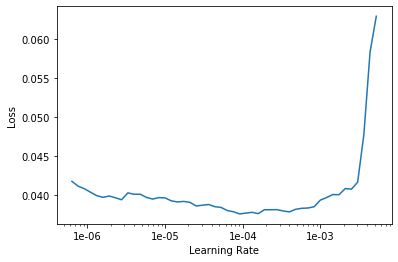

In [126]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [127]:
lr = slice(1e-5, 1e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

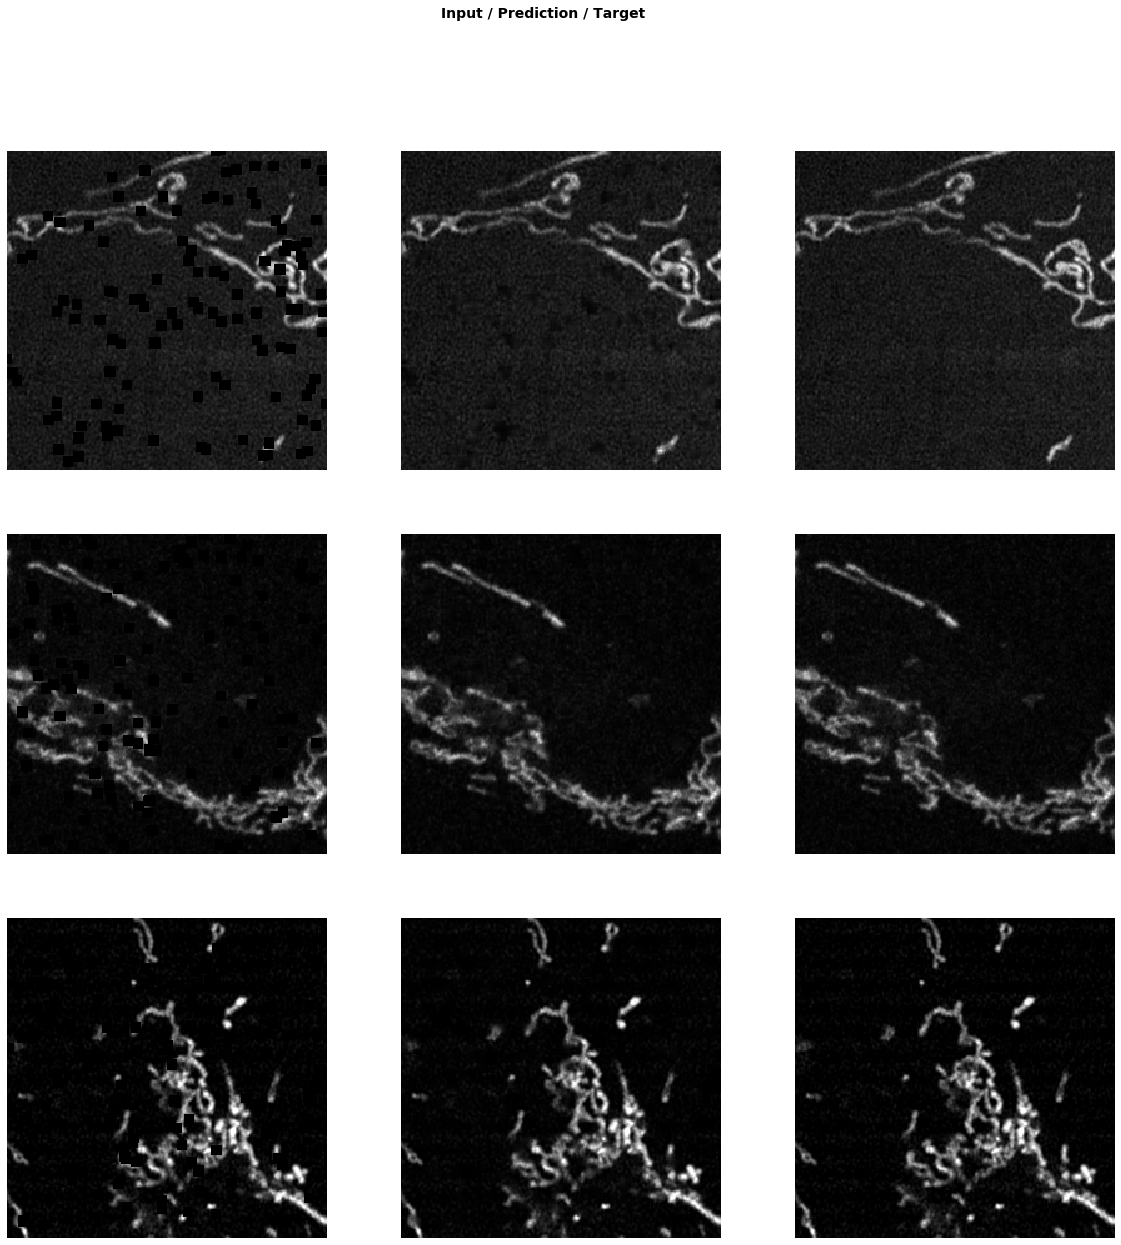

In [128]:
learn.show_results(rows=3, figsize=(20, 20), cmap='gray')

In [133]:
learn = learn.load(f'{nb_name}.2a')

In [139]:
model_pth

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/critics')

In [142]:
learn.export(model_pth/f'{nb_name}.2a.pkl')